## **Class 15: Regularization**
- **Source**: I, Yeh (1988). Modeling of strength of high-performance concrete using artificial neural networks. Published in Cement and Concrete Research, Vol. 28, No. 12
- **Date**: 02/05/2025
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
df_raw =  pd.read_excel('../data/raw/concrete_data.xls')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [3]:
df_raw.sample(10, random_state=2025)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
565,295.80,0.00,0.00,185.70,0.00,1091.4,769.30,7,14.843729
690,288.00,192.00,0.00,192.00,0.00,932.0,717.80,7,23.523542
636,300.00,0.00,0.00,184.00,0.00,1075.0,795.00,28,26.848195
43,380.00,0.00,0.00,228.00,0.00,932.0,670.00,180,53.104131
720,203.50,305.30,0.00,203.50,0.00,963.4,630.00,90,51.863764
346,213.74,0.00,174.74,154.79,10.16,1053.5,776.35,28,40.148187
149,425.00,106.30,0.00,153.50,16.50,852.1,887.10,56,64.300532
376,376.00,0.00,0.00,214.60,0.00,1003.5,762.36,28,31.971002
605,236.00,0.00,0.00,194.00,0.00,968.0,885.00,3,6.467285
436,172.38,13.61,172.37,156.76,4.14,1006.3,856.40,28,33.687797


|Name|Description|Type|Units|
|----|-----------|----|-----|
|cement|Cement (component 1)(kg in a m^3 mixture)|Float|kg/m^3|
|blast_furnace_slag|Blast Furnace Slag (component 2)(kg in a m^3 mixture)|Float|kg/m^3|
|fly_ash|Fly Ash (component 3)(kg in a m^3 mixture)|Float|kg/m^3|
|water|Water (component 4)(kg in a m^3 mixture)|Float|kg/m^3|
|superplasticizer|Superplasticizer (component 5)(kg in a m^3 mixture)|Float|kg/m^3|
|coarse_aggregate|Coarse Aggregate (component 6)(kg in a m^3 mixture)|Float|kg/m^3|
|fine_aggregate|Fine Aggregate (component 7)(kg in a m^3 mixture)|Float|kg/m^3|
|age|Age (day)|Int|day|
|compressive_strength|Concrete compressive strength(MPa, megapascals)|Float|megapascals|

### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
df_baking = df_raw.copy()
df_baking.columns = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength']
df_baking['log_age'] = np.log(df_baking['age'])
df_baking.drop('age', axis=1, inplace=True)
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   blast_furnace_slag    1030 non-null   float64
 2   fly_ash               1030 non-null   float64
 3   water                 1030 non-null   float64
 4   superplasticizer      1030 non-null   float64
 5   coarse_aggregate      1030 non-null   float64
 6   fine_aggregate        1030 non-null   float64
 7   compressive_strength  1030 non-null   float64
 8   log_age               1030 non-null   float64
dtypes: float64(9)
memory usage: 72.6 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [5]:
df_train, df_test = train_test_split(df,test_size=0.2,random_state=2025)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                824 non-null    float64
 1   blast_furnace_slag    824 non-null    float64
 2   fly_ash               824 non-null    float64
 3   water                 824 non-null    float64
 4   superplasticizer      824 non-null    float64
 5   coarse_aggregate      824 non-null    float64
 6   fine_aggregate        824 non-null    float64
 7   compressive_strength  824 non-null    float64
 8   log_age               824 non-null    float64
dtypes: float64(9)
memory usage: 58.1 KB


In [6]:
display(df_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
cement,824.0,278.074320,105.202346,102.000000,190.255000,255.000000,350.000000,540.000000
blast_furnace_slag,824.0,76.231311,86.630413,0.000000,0.000000,26.000000,145.000000,359.400000
fly_ash,824.0,53.503083,64.244911,0.000000,0.000000,0.000000,118.270000,200.100000
water,824.0,181.901396,21.936752,121.750000,164.900000,185.700000,193.000000,247.000000
superplasticizer,824.0,6.186624,6.094910,0.000000,0.000000,6.325000,10.300000,32.200000
coarse_aggregate,824.0,971.264211,77.333406,801.000000,932.000000,968.000000,1028.400000,1134.300000
fine_aggregate,824.0,773.822100,80.960805,594.000000,729.750000,779.510000,825.125000,992.600000
compressive_strength,824.0,35.512051,16.683885,2.331808,23.728144,33.729166,45.367521,82.599225
log_age,824.0,3.177558,1.189706,0.000000,2.465771,3.332205,4.025352,5.899897


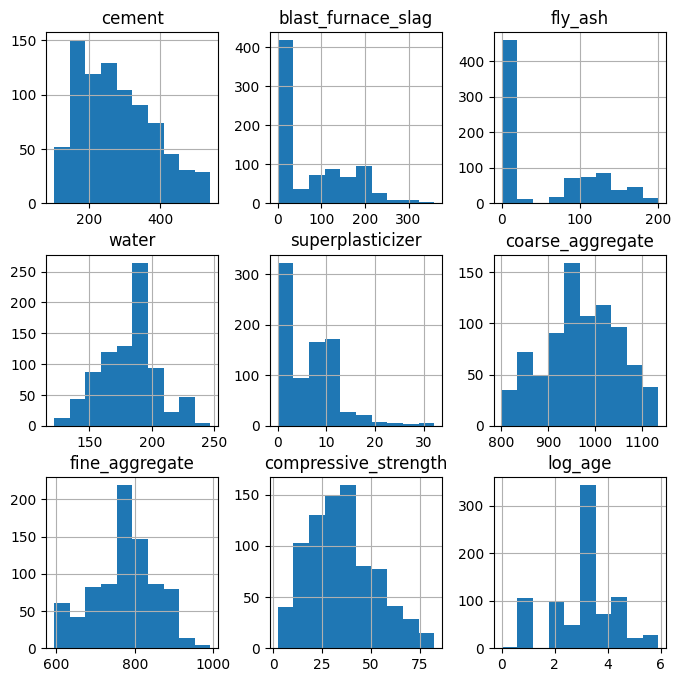

In [7]:
df_train.hist(figsize=(8,8))
plt.show()

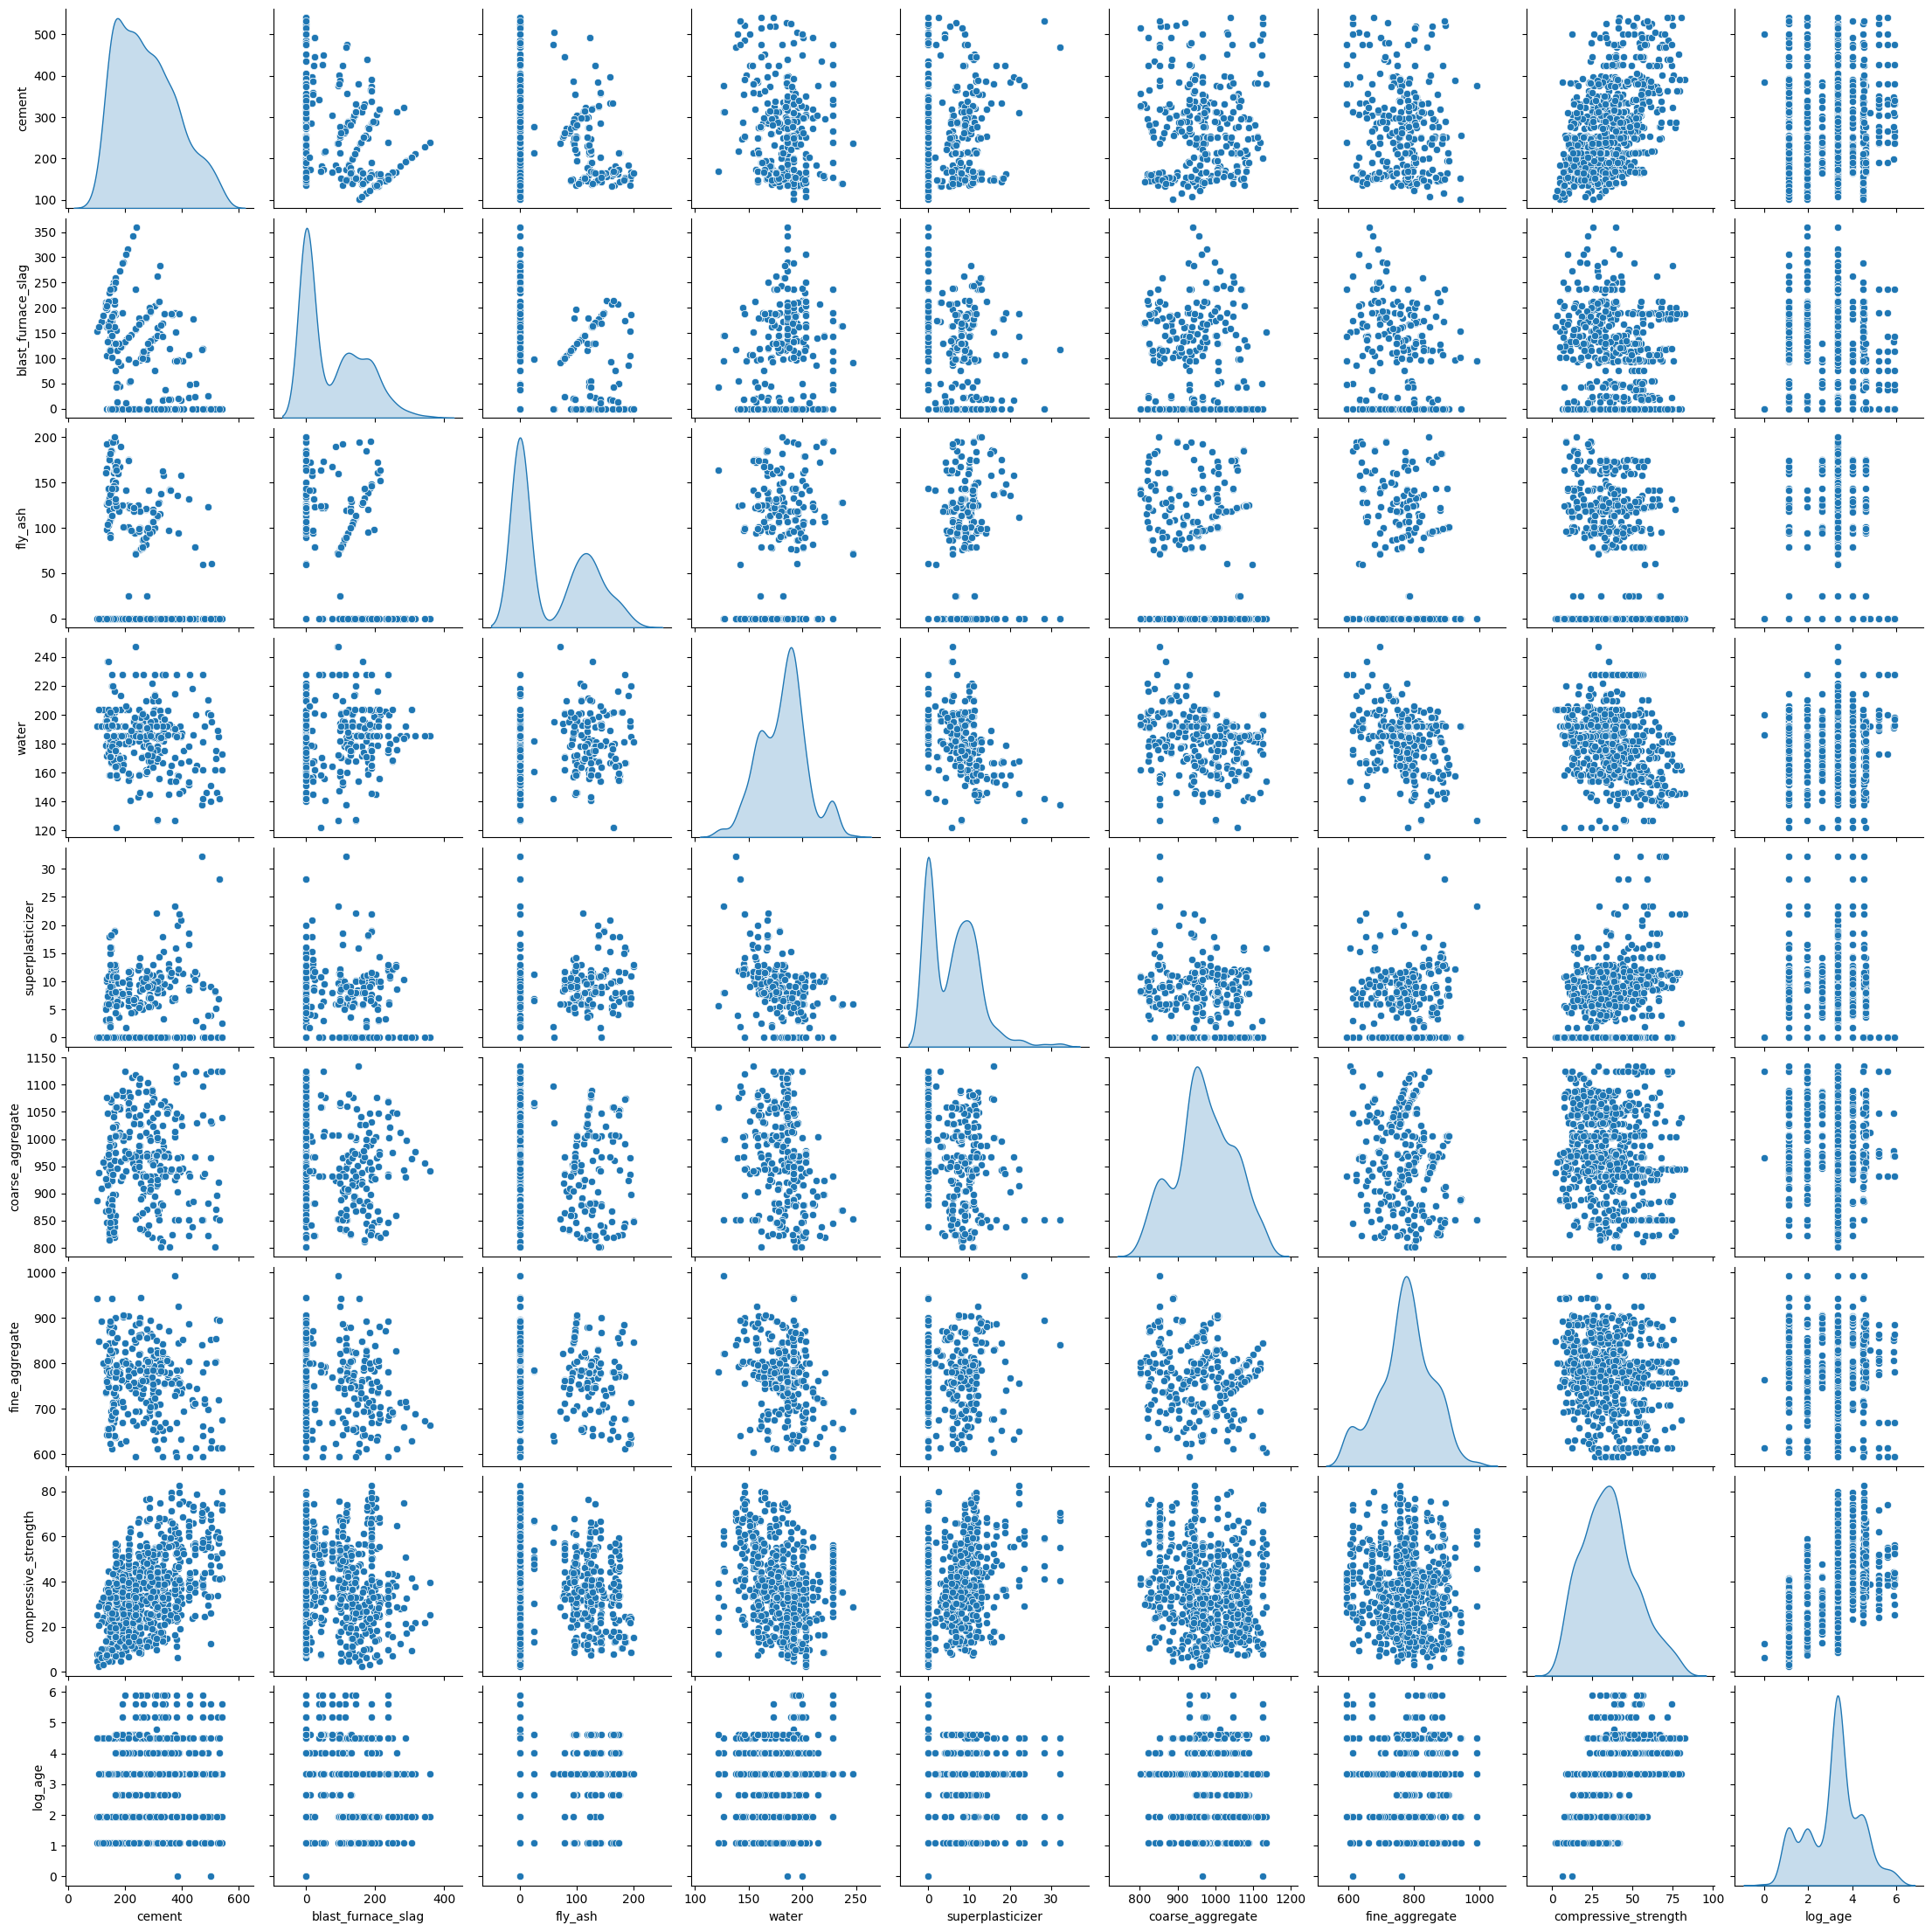

In [8]:
sns.pairplot(df_train, diag_kind='kde')
plt.show()

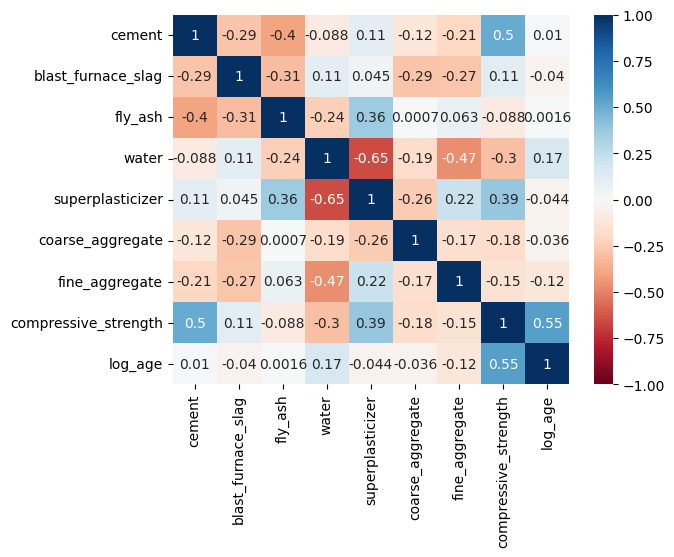

In [9]:
sns.heatmap(df_train.corr(),vmin=-1,vmax=1,cmap='RdBu',annot=True)
plt.show()

#### Rule 0:
Assume that there is a linear relation between the independent variables and the dependent variables

#### Rule 1:
Variables should not be too correlated (More than 0.75 or less than -0.75)

#### Rule 2:
Residuals of our prediction should have a symetrical distribution

#### Rule 3:
The Residuals should have a homogeneous dispersion

### **4. Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [10]:
X_train = df_train.drop('compressive_strength', axis=1)
y_train = df_train['compressive_strength']
X_test = df_test.drop('compressive_strength', axis=1)
y_test = df_test['compressive_strength']

In [11]:
num_proc = Pipeline([
    ('scaler', MinMaxScaler())
])
lreg_p = Pipeline([
    ('num_processer', num_proc),
    ('lreg', LinearRegression())
])

In [12]:
lreg_p.fit(X_train, y_train)

Pipeline(steps=[('num_processer', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('lreg', LinearRegression())])

In [13]:
y_hat = lreg_p.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_hat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2: {r2_score(y_test, y_hat)}')

MSE: 54.370993977017875
RMSE: 7.373668963075158
R2: 0.8058989092940341


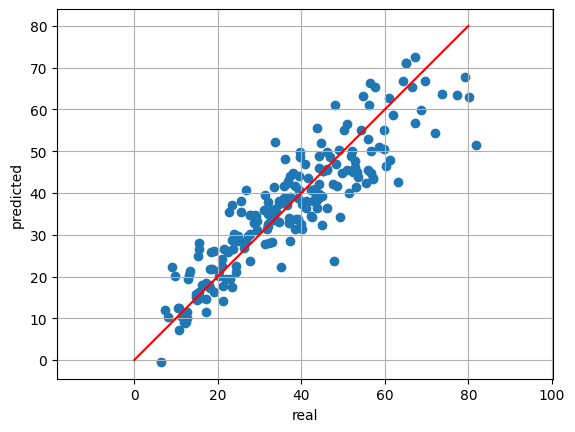

In [14]:
plt.scatter(y_test, y_hat)
plt.plot([0,80],[0,80],color='r')
plt.xlabel('real')
plt.ylabel('predicted')
plt.grid(True)
plt.axis('equal')
plt.show()

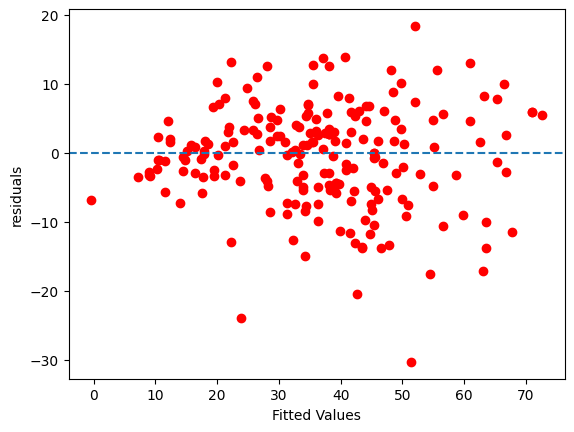

In [15]:
resid = y_hat-y_test
plt.scatter(y_hat,resid,c='r')
plt.axhline(0,linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('residuals')
plt.show()

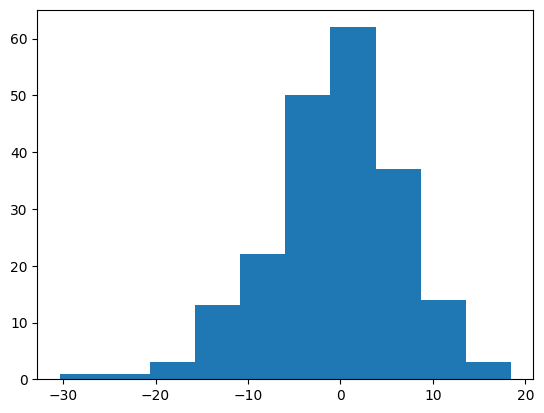

In [16]:
plt.hist(resid)
plt.show()

In [17]:
print(f'intercept:{lreg_p["lreg"].intercept_:.2f}') # beta_0
print(f'coeficients:{lreg_p["lreg"].coef_}') # list of beta (beta_1, beta_2, beta_3.....beta_n)

intercept:-37.31
coeficients:[ 59.67384493  41.84843564  19.50985875 -13.41924777   5.53703641
  10.30327249  15.9278382   51.37953981]


$-32.89 + cement*0.122 + slag*0.105 + ash* 0.094 + water* -0.1296... $

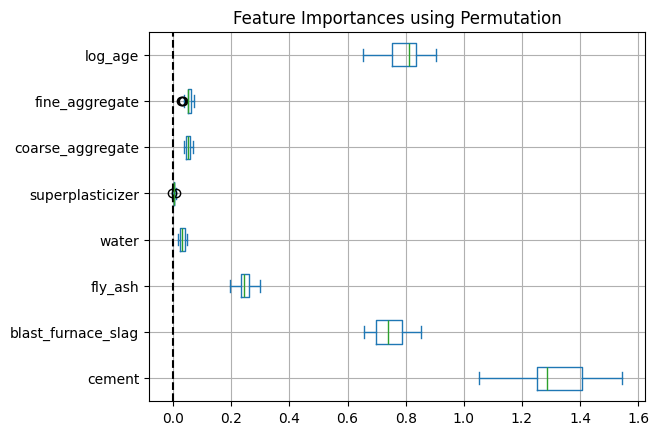

In [18]:
importance = permutation_importance(lreg_p, X_test, y_test, n_repeats=25, random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_test.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color='k',linestyle='--')
ax.set_title('Feature Importances using Permutation')
ax.grid(True)
plt.show()

In [19]:
#Lasso
cv = RepeatedKFold(n_splits=15,n_repeats=5, random_state = 2025)
lreg_lasso = LassoCV(alphas=np.arange(0,1,0.001), cv=cv)
lreg_lasso.fit(X_train,y_train)

/workspaces/4geeks_class/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/workspaces/4geeks_class/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19407.107427828334, tolerance: 21.390999841582175
  model = cd_fast.enet_coordinate_descent_gram(
/workspaces/4geeks_class/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/workspaces/4geeks_class/.venv/lib/python3.12/site-packages/s

LassoCV(alphas=array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055,...
       0.945, 0.946, 0.947, 0.948, 0.949, 0.95 , 0.951, 0.952, 0.953,
       0.954, 0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962,
       0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971,
       0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 ,
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999]),
        cv=RepeatedKFold(n_repeats=5, n_splits=15, random_state=2025))

In [20]:
lreg_lasso.alpha_

np.float64(0.001)

In [21]:
#Lasso
cv = RepeatedKFold(n_splits=15,n_repeats=5,random_state=2025)
lreg_ridge = RidgeCV(alphas=np.arange(0,1,0.01),cv=cv)
lreg_ridge.fit(X_train,y_train)

RidgeCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=5, n_splits=15, random_state=2025))

In [22]:
lreg_ridge.alpha_

np.float64(0.99)

In [23]:
num_proc = Pipeline([
    ('scaler', MinMaxScaler())
])
lreg_ridge_p = Pipeline([
    ('num_processer', num_proc),
    ('lreg_ridge', Ridge(alpha=0.99))
])

In [24]:
lreg_ridge_p.fit(X_train, y_train)

Pipeline(steps=[('num_processer', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('lreg_ridge', Ridge(alpha=0.99))])

In [25]:
y_hat = lreg_ridge_p.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_hat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2: {r2_score(y_test, y_hat)}')

MSE: 55.8133929578476
RMSE: 7.470836161892964
R2: 0.8007496340107726


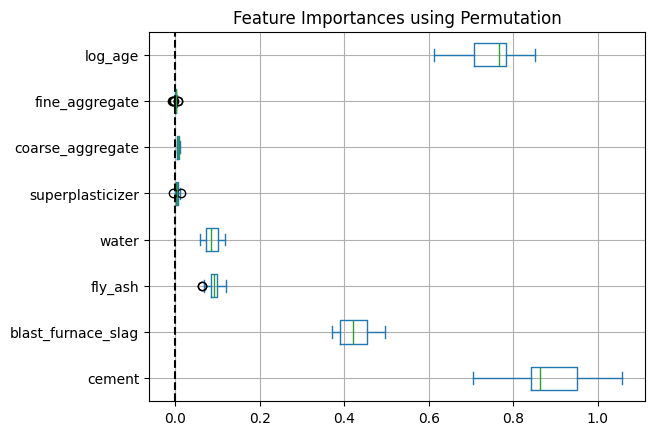

In [26]:
importance = permutation_importance(lreg_ridge_p, X_test, y_test, n_repeats=25, random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_test.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color='k',linestyle='--')
ax.set_title('Feature Importances using Permutation')
ax.grid(True)
plt.show()